In [1]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import math

In [2]:
from trnasimtools.serialize import SerializeTwoCodonMultiTranscript
import os

In [3]:
def read_sim(path_pref, seed_start=1, seed_end=3, seed_incr=1, time_limit=None):
    """ 
    Reads in output for an arbitrary number of simulation trials 
    (with different seeds) and concatenates results into a single
    dataset.
    """
    df_master = pd.read_csv(f"{path_pref}_{seed_start}.tsv", sep="\t")
    df_master["seed"] = str(seed_start)
    for i in range(seed_start+1, seed_end+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    if time_limit is not None:
        df_master = df_master[df_master.time < time_limit]
    return df_master

from bisect import bisect_left
def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before
    
def concat_sims(path_pref, max_seed):
    df_master = pd.read_csv(f"{path_pref}_1.tsv", sep="\t")
    df_master["seed"] = str(1)
    for i in range(2, max_seed+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    
    return df_master
    
def get_average_protein(path, perc_good, time, max_seed):
    df_master = concat_sims(path, max_seed)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    #tmp = df_master.loc[df_master['time'] == time].groupby(["species"])["protein"].mean().reset_index()
    tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()
    tmp["delta"] = tmp.groupby(["species"])["protein"].diff(periods=8)
    tmp = tmp[(tmp.time == time) | (tmp.time == 50.0)]
    return tmp

def get_average_protein_no_delta(path, time, max_seed):
    df_master = concat_sims(path, max_seed)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    tmp = df_master.groupby(["time", "species"])["protein"].mean().reset_index()
    #tmp = tmp[(tmp.time == time) | (tmp.time == 50.0)]
    return tmp

# Now, run sweep of charging rates 10^1 to 5*10^2 & binding rates 10^3 to 10^5
ecol_mrna_composition = [(x/100, round(1 - (x/100), 2)) for x in range(1, 100)]
time_limit = 200
time_step = 5
transcript_lens = [1000]
cellular_transcript_copy_number = 100
gfp_transcript_copy_number = 10
ribosome_copy_number = 500
total_trna = 2500
#ecol_rbs_rate = [100000.0]
ecol_rbs_rates = [1000.0, 5000.0, 10000.0, 50000.0, 100000.0]
ribosome_binding_rate = 0.001
trna_charging_rates = [10.0, 50.0, 100.0, 250.0, 500.0, 1000.0, 5000.0]
transcript_names = ["cellularProtein", "GFP"]
trna_composition = (0.7, 0.3)
ecol_mrna_composition = ecol_mrna_composition
gfp_mrna_compositions = [(0.7, 0.3)]
ribosome_speed = 3 
ribosome_footprint = 15

date = "feb-27-2024"

In [4]:
# simulation parameters 
time_limit = 200
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 100
gfp_transcript_copy_number = 10
ribosome_copy_number = 500
total_trna = 2500
ecol_rbs_rate = 100000.0
ribosome_binding_rates = [10000.0, 30000.0, 100000.0, 300000.0, 1000000.0, 3000000.0]
trna_charging_rates = [50.0, 100.0, 250.0, 500.0, 1000.0, 5000.0]
#trna_charging_rates = [30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0]
transcript_names = ["cellularProtein", "GFP"]
trna_composition = [(0.7, 0.3)]
ecol_mrna_composition = (0.6, 0.4) # Making e. coli codon usage less optimal
gfp_mrna_compositions = [(0.9, 0.1), (0.7, 0.3), (0.5, 0.5), (0.3, 0.7), (0.1, 0.9)]
ribosome_speed = 3
ribosome_footprint = 15

date = "march-7-2024"

In [5]:
!mkdir ../output/march-7-2024
!mkdir ../yaml/march-7-2024

In [10]:
for trna_prop in trna_composition:
    for comp in gfp_mrna_compositions:
        serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[ecol_mrna_composition, comp],
                                                       trna_proportion=trna_prop,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
        serializer.serialize(f"../yaml/{date}")

In [11]:
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for charging_rate in trna_charging_rates:
            for binding_rate in ribosome_binding_rates:
                for seed in range(1, 4):
                    cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {gfp_transcript_copy_number} " + \
                      f"{ribosome_copy_number} {total_trna} {ecol_rbs_rate} {binding_rate} {charging_rate} {charging_rate} " + \
                      f"../output/{date} {ribosome_speed} {ribosome_footprint}"
                    stream.write(cmd)
                    stream.write("\n")

stopped here

In [63]:
gfp_mrna_compositions = [(0.9, 0.1), (0.7, 0.3), (0.5, 0.5), (0.3, 0.7), (0.1, 0.9)]
#gfp_mrna_compositions = [(0.9, 0.1), (0.7, 0.3), (0.5, 0.5), (0.1, 0.9)]
df_master = None

for charging_rate in trna_charging_rates:
    df_charge = None
    for binding_rate in ribosome_binding_rates:
        df_binding = None
        for codons in gfp_mrna_compositions:
            path = f"../output/{date}/two_codon_multi_transcript_0.6_0.4_{codons[0]}_{codons[1]}_0.7_0.3" + \
                   f"_{cellular_transcript_copy_number}_{gfp_transcript_copy_number}_{ribosome_copy_number}_{total_trna}" + \
                   f"_{ecol_rbs_rate}_{binding_rate}_{charging_rate}_{charging_rate}"
            tmp = get_average_protein(path, 0.5, 200, 3)
            tmp["codon"] = float(codons[0])
            tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
            if df_binding is not None:
                df_binding = df_binding.append(tmp, ignore_index=True)
            else:
                df_binding = tmp
        df_binding["gfp_rbs"] = binding_rate
        if df_charge is not None:
            df_charge = df_charge.append(df_binding, ignore_index=True)
        else:
            df_charge = df_binding
    df_charge["charging_rate"] = charging_rate
    if df_master is not None:
        df_master = df_master.append(df_charge, ignore_index=True)
    else:
        df_master = df_charge

df_master = df_master[(df_master.time == 200.0)]
df_master["codon"] = df_master["codon"].div(1).round(1)

/tmp/ipykernel_3758862/1584340.py:51: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()


In [54]:
df_master

,time,species,protein,ribo_density,delta,codon,gfp_rbs,charging_rate
9,200.0,ATA_charged,29.000000,0.000000,7.000000,0.9,10000.0,50.0
10,200.0,ATA_uncharged,721.000000,0.000000,-7.000000,0.9,10000.0,50.0
11,200.0,GFP,18.333333,0.000000,4.666667,0.9,10000.0,50.0
12,200.0,TTT_charged,655.666667,0.000000,-29.666667,0.9,10000.0,50.0
13,200.0,TTT_uncharged,1094.333333,0.000000,29.666667,0.9,10000.0,50.0
...,...,...,...,...,...,...,...,...
2587,200.0,TTT_uncharged,69.000000,0.000000,-6.666667,0.1,3000000.0,5000.0
2588,200.0,__GFP_rbs,9.333333,0.000000,0.000000,0.1,3000000.0,5000.0
2589,200.0,__cellularProtein_rbs,99.333333,0.000000,0.666667,0.1,3000000.0,5000.0
2590,200.0,free ribosome,292.666667,0.000000,1.333333,0.1,3000000.0,5000.0


In [64]:
df_master["gfp_rbs_foldx"] = df_master["gfp_rbs"] / ecol_rbs_rate
#df = df[(df.species == "cellularProtein") | (df.species == "GFP")]
df = df_master.pivot_table(index=['gfp_rbs_foldx', 'codon', 'charging_rate'], columns='species', values='protein').reset_index()

df["TTT_charged"] = df["TTT_charged"] / (total_trna*0.7)
df["ATA_charged"] = df["ATA_charged"] / (total_trna*0.3)
df["free ribosome"] = df["free ribosome"] / ribosome_copy_number

df['cellularProtein_max'] = df.groupby(['codon', 'charging_rate'])['cellularProtein'].transform('max')
df['cellularProtein_norm'] = df['cellularProtein']/df["cellularProtein_max"]

In [56]:
df

species,gfp_rbs_foldx,codon,charging_rate,ATA_charged,ATA_uncharged,GFP,TTT_charged,TTT_uncharged,__GFP_rbs,__cellularProtein_rbs,cellularProtein,free ribosome,cellularProtein_max,cellularProtein_norm
0,0.1,0.1,50.0,0.040889,719.333333,17.666667,0.384762,1076.666667,10.000000,96.000000,17786.666667,0.082000,17786.666667,1.000000
1,0.1,0.1,100.0,0.075111,693.666667,33.333333,0.409714,1033.000000,10.000000,96.000000,34101.666667,0.176667,34101.666667,1.000000
2,0.1,0.1,250.0,0.246222,565.333333,63.333333,0.524571,832.000000,10.000000,97.000000,69845.000000,0.356000,69845.000000,1.000000
3,0.1,0.1,500.0,0.464889,401.333333,92.333333,0.660190,594.666667,10.000000,98.666667,96559.000000,0.456000,96559.000000,1.000000
4,0.1,0.1,1000.0,0.723111,207.666667,111.000000,0.822857,310.000000,10.000000,99.666667,112472.000000,0.582667,112472.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,30.0,0.9,100.0,0.089778,682.666667,9960.000000,0.368000,1106.000000,9.666667,96.333333,33272.666667,0.176000,34112.000000,0.975395
140,30.0,0.9,250.0,0.251556,561.333333,19948.000000,0.477905,913.666667,9.666667,98.000000,67680.000000,0.324667,69894.000000,0.968323
141,30.0,0.9,500.0,0.502222,373.333333,27581.666667,0.645333,620.666667,10.000000,98.333333,93405.000000,0.472000,96568.666667,0.967239
142,30.0,0.9,1000.0,0.706667,220.000000,32367.333333,0.788571,370.000000,9.666667,99.666667,109016.000000,0.528667,112443.000000,0.969522


In [65]:
df.to_csv("regression_charging_rate.csv")

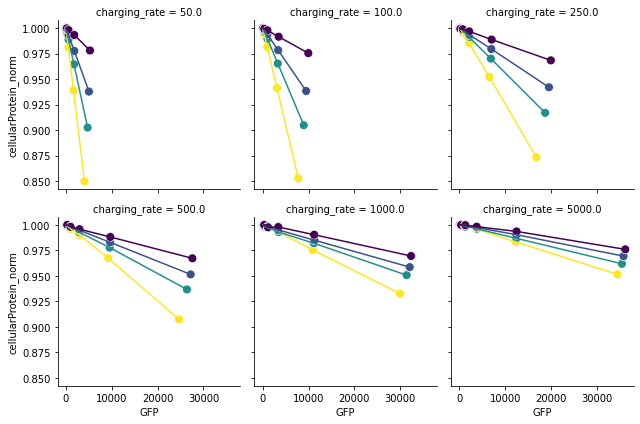

In [57]:
g = sns.FacetGrid(df, col="charging_rate", col_wrap=3)
g.map_dataframe(sns.scatterplot, x="GFP", y="cellularProtein_norm", hue = "codon", s=80, palette="viridis_r")
g.map_dataframe(sns.lineplot, x="GFP", y="cellularProtein_norm", hue = "codon", palette="viridis_r")

#sns.scatterplot(data=df, x = "GFP", y = "cellularProtein", hue = "codon", s=80, palette="viridis_r")
#plt.xscale("log")
#plt.xlabel("GFP expression")
#plt.ylabel("Background gene expression")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
#handles, labels = plt.gca().get_legend_handles_labels()
#plt.legend(reversed(handles), reversed(labels), title="pref. codon use", loc="lower left")

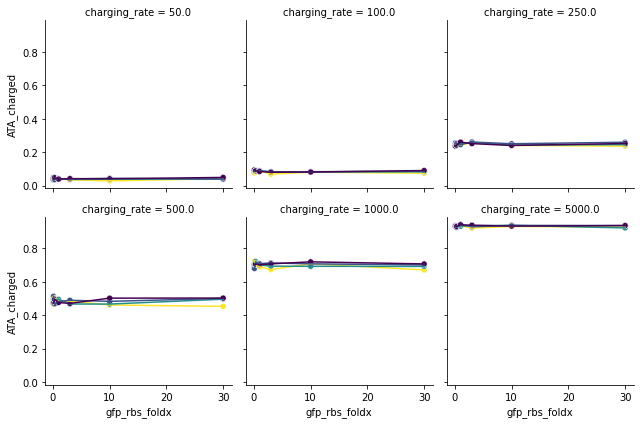

In [58]:
g = sns.FacetGrid(df, col="charging_rate", col_wrap=3)
g.map_dataframe(sns.scatterplot, x="gfp_rbs_foldx", y="ATA_charged", hue = "codon", palette="viridis_r")
g.map_dataframe(sns.lineplot, x="gfp_rbs_foldx", y="ATA_charged", hue = "codon", palette="viridis_r")
#g.map_dataframe(sns.lineplot, x="GFP", y="cellularProtein_norm", hue = "codon", palette="viridis_r")

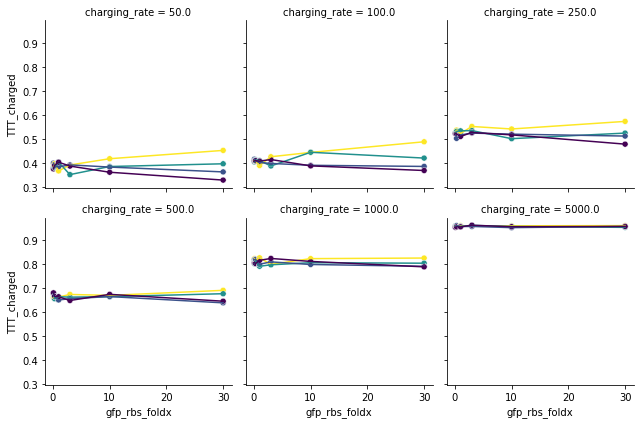

In [59]:
g = sns.FacetGrid(df, col="charging_rate", col_wrap=3)
g.map_dataframe(sns.scatterplot, x="gfp_rbs_foldx", y="TTT_charged", hue = "codon", palette="viridis_r")
g.map_dataframe(sns.lineplot, x="gfp_rbs_foldx", y="TTT_charged", hue = "codon", palette="viridis_r")
#g.map_dataframe(sns.lineplot, x="GFP", y="cellularProtein_norm", hue = "codon", palette="viridis_r")

In [10]:
df_ribo = df_master.copy()
df_ribo["gfp_rbs_foldx"] = df_ribo["gfp_rbs"] / ecol_rbs_rate
df_ribo = df_ribo.pivot_table(index=['gfp_rbs_foldx', 'codon', 'charging_rate'], columns='species', values='ribo_density').reset_index()
df_ribo["cell_ribo_usage"] = df_ribo["cellularProtein"] / ribosome_copy_number * cellular_transcript_copy_number
df_ribo["gfp_ribo_usage"] = df_ribo["GFP"] / ribosome_copy_number * gfp_transcript_copy_number

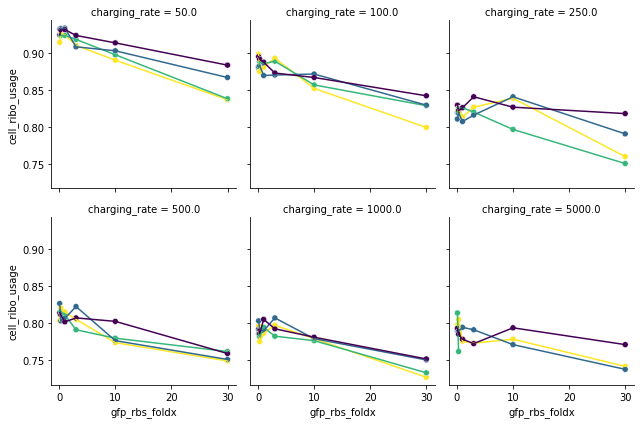

In [12]:
g = sns.FacetGrid(df_ribo, col="charging_rate", col_wrap=3)
g.map_dataframe(sns.scatterplot, x="gfp_rbs_foldx", y="cell_ribo_usage", hue = "codon", palette="viridis_r")
g.map_dataframe(sns.lineplot, x="gfp_rbs_foldx", y="cell_ribo_usage", hue = "codon", palette="viridis_r")
#g.map_dataframe(sns.lineplot, x="GFP", y="cellularProtein_norm", hue = "codon", palette="viridis_r")

In [4]:
# simulation parameters 
time_limit = 200
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 100
gfp_transcript_copy_number = 10
ribosome_copy_number = 500
total_trna = 2500
ecol_rbs_rate = 100000.0
ribosome_binding_rates = [10000.0, 30000.0, 100000.0, 300000.0, 1000000.0, 3000000.0]
trna_charging_rates = [50.0, 100.0, 250.0, 500.0, 1000.0, 5000.0]
transcript_names = ["cellularProtein", "GFP"]
trna_composition = [(0.7, 0.3)]
ecol_mrna_composition = (0.6, 0.4) # Making e. coli codon usage less optimal
gfp_mrna_compositions = [(0.9, 0.1), (0.7, 0.3), (0.5, 0.5), (0.3, 0.7), (0.1, 0.9)]
ribosome_speed = 0.5
ribosome_footprint = 15

date = "march-18-2024"

In [67]:
!mkdir ../output/march-18-2024
!mkdir ../yaml/march-18-2024

In [69]:
for trna_prop in trna_composition:
    for comp in gfp_mrna_compositions:
        serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[ecol_mrna_composition, comp],
                                                       trna_proportion=trna_prop,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
        serializer.serialize(f"../yaml/{date}")

In [70]:
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for charging_rate in trna_charging_rates:
            for binding_rate in ribosome_binding_rates:
                for seed in range(1, 4):
                    cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {gfp_transcript_copy_number} " + \
                      f"{ribosome_copy_number} {total_trna} {ecol_rbs_rate} {binding_rate} {charging_rate} {charging_rate} " + \
                      f"../output/{date} {ribosome_speed} {ribosome_footprint}"
                    stream.write(cmd)
                    stream.write("\n")

In [6]:
#gfp_mrna_compositions = [(0.9, 0.1), (0.7, 0.3), (0.5, 0.5), (0.3, 0.7), (0.1, 0.9)]
gfp_mrna_compositions = [(0.9, 0.1), (0.7, 0.3), (0.5, 0.5), (0.3, 0.7)]
df_master = None

for charging_rate in trna_charging_rates:
    df_charge = None
    for binding_rate in ribosome_binding_rates:
        df_binding = None
        for codons in gfp_mrna_compositions:
            path = f"../output/{date}/two_codon_multi_transcript_0.6_0.4_{codons[0]}_{codons[1]}_0.7_0.3" + \
                   f"_{cellular_transcript_copy_number}_{gfp_transcript_copy_number}_{ribosome_copy_number}_{total_trna}" + \
                   f"_{ecol_rbs_rate}_{binding_rate}_{charging_rate}_{charging_rate}"
            tmp = get_average_protein(path, 0.5, 200, 3)
            tmp["codon"] = float(codons[0])
            tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
            if df_binding is not None:
                df_binding = df_binding.append(tmp, ignore_index=True)
            else:
                df_binding = tmp
        df_binding["gfp_rbs"] = binding_rate
        if df_charge is not None:
            df_charge = df_charge.append(df_binding, ignore_index=True)
        else:
            df_charge = df_binding
    df_charge["charging_rate"] = charging_rate
    if df_master is not None:
        df_master = df_master.append(df_charge, ignore_index=True)
    else:
        df_master = df_charge

df_master = df_master[(df_master.time == 200.0)]
df_master["codon"] = df_master["codon"].div(1).round(1)

/tmp/ipykernel_3088159/1584340.py:51: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()


In [7]:
df_master["gfp_rbs_foldx"] = df_master["gfp_rbs"] / ecol_rbs_rate
#df = df[(df.species == "cellularProtein") | (df.species == "GFP")]
df = df_master.pivot_table(index=['gfp_rbs_foldx', 'codon', 'charging_rate'], columns='species', values='protein').reset_index()

df["TTT_charged"] = df["TTT_charged"] / (total_trna*0.7)
df["ATA_charged"] = df["ATA_charged"] / (total_trna*0.3)
df["free ribosome"] = df["free ribosome"] / ribosome_copy_number

df['cellularProtein_max'] = df.groupby(['codon', 'charging_rate'])['cellularProtein'].transform('max')
df['cellularProtein_norm'] = df['cellularProtein']/df["cellularProtein_max"]

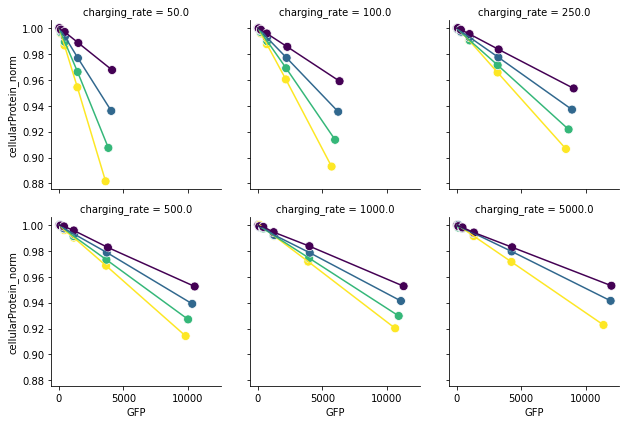

In [8]:
g = sns.FacetGrid(df, col="charging_rate", col_wrap=3)
g.map_dataframe(sns.scatterplot, x="GFP", y="cellularProtein_norm", hue = "codon", s=80, palette="viridis_r")
g.map_dataframe(sns.lineplot, x="GFP", y="cellularProtein_norm", hue = "codon", palette="viridis_r")

#sns.scatterplot(data=df, x = "GFP", y = "cellularProtein", hue = "codon", s=80, palette="viridis_r")
#plt.xscale("log")
#plt.xlabel("GFP expression")
#plt.ylabel("Background gene expression")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
#handles, labels = plt.gca().get_legend_handles_labels()
#plt.legend(reversed(handles), reversed(labels), title="pref. codon use", loc="lower left")

In [9]:
df.to_csv("regression_charging_rate_2.csv")